In [1]:
%matplotlib inline 

from utils import *

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
wk_dir = os.getcwd()

In [3]:
data_dir = wk_dir + "/../data/kg/cd-redux/sample/"

In [4]:
model_dir = data_dir + "/models/"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

### Finetuning from scratch(?)

In [5]:
vgg = Vgg16()
model = vgg.model

In [6]:
batches = get_batches(data_dir + "/train/", shuffle=False, batch_size=1)
val_batches = get_batches(data_dir + "/valid/", shuffle=False, batch_size=1)

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


Using a batch_size of 1 doesn't mean we're not getting all the images - we are.

**What is batch_size?**

Number of images to process at once. We try to process as many images at a time as our graphics card allows.

Apparently when we use a batch_size of 1 it's because we're doing preprocessing on the CPU (??)

In [7]:
import bcolz
def save_array(fname, arr):
    c = bcolz.carray(arr, rootdir=fname, mode="w")
    c.flush()
def load_array(fname):
    return bcolz.open(fname)[:]

In [8]:
val_data = get_data(data_dir + "/valid/")

Found 50 images belonging to 2 classes.


In [9]:
trn_data = get_data(data_dir + "/train/")

Found 200 images belonging to 2 classes.


```
def get_data(path, target_size=(224,224)):
    batches = get_batches(
        path, 
        shuffle=False, 
        batch_size=1, 
        class_mode=None, 
        target_size=target_size
    )
    return np.concatenate(
        [batches.next() for i in range(batches.nb_sample)]
    )

```
**What's the difference between get_data and get_batches?**

* they take roughly the same inputs
* get_data always has batch_size=1 (so it's for preprocessing?)
* get_batches returns the gen.flow_from_directory iterator(?)
* get_data returns that same iterator but concatenated into a numpy array

```

def get_batches(
        dirname, 
        gen=image.ImageDataGenerator(), 
        shuffle=True, 
        batch_size=4, 
        class_mode='categorical',
        target_size=(224,224)
    ):
    return gen.flow_from_directory(
        dirname, 
        target_size=target_size,
        class_mode=class_mode, 
        shuffle=shuffle, 
        batch_size=batch_size
    )
```

In [10]:
val_data[:1]

array([[[[ 153.,  153.,  154., ...,  157.,  159.,  162.],
         [ 153.,  153.,  154., ...,  157.,  159.,  162.],
         [ 149.,  149.,  150., ...,  151.,  153.,  155.],
         ..., 
         [ 251.,  251.,  252., ...,  251.,  249.,  248.],
         [ 251.,  251.,  252., ...,  251.,  249.,  248.],
         [ 251.,  251.,  252., ...,  251.,  249.,  248.]],

        [[ 193.,  193.,  194., ...,  198.,  200.,  203.],
         [ 193.,  193.,  194., ...,  198.,  200.,  203.],
         [ 189.,  189.,  190., ...,  192.,  194.,  196.],
         ..., 
         [ 255.,  255.,  255., ...,  248.,  246.,  245.],
         [ 255.,  255.,  255., ...,  248.,  246.,  245.],
         [ 255.,  255.,  255., ...,  248.,  246.,  245.]],

        [[ 255.,  255.,  255., ...,  255.,  255.,  255.],
         [ 255.,  255.,  255., ...,  255.,  255.,  255.],
         [ 251.,  251.,  252., ...,  255.,  255.,  255.],
         ..., 
         [ 255.,  255.,  255., ...,  255.,  253.,  252.],
         [ 255.,  255.,

In [11]:
trn_data[:1]

array([[[[ 112.,  119.,  128., ...,  128.,  127.,  127.],
         [ 119.,  128.,  136., ...,  133.,  127.,  127.],
         [ 127.,  136.,  144., ...,  141.,  127.,  127.],
         ..., 
         [ 123.,  128.,  132., ...,  136.,  127.,  127.],
         [ 120.,  125.,  132., ...,  135.,  127.,  127.],
         [ 127.,  127.,  127., ...,  127.,  127.,  127.]],

        [[   3.,    2.,    3., ...,    6.,    0.,    0.],
         [   2.,    0.,    1., ...,    2.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         ..., 
         [   4.,    2.,    0., ...,    0.,    0.,    0.],
         [   4.,    2.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.]],

        [[ 255.,  255.,  245., ...,  241.,  255.,  255.],
         [ 255.,  255.,  251., ...,  244.,  255.,  255.],
         [ 255.,  255.,  255., ...,  253.,  255.,  255.],
         ..., 
         [ 254.,  252.,  249., ...,  255.,  255.,  255.],
         [ 255.,  255.,

In [12]:
val_data.shape

(50, 3, 224, 224)

Interpretation: 50 images, 3 color channels (and the value of R/G/B), 224 by 224 pixels.

In [13]:
save_array(model_dir + "train_data.bc", trn_data)
save_array(model_dir + "valid_data.bc", val_data)

Why is this necessary? The notes say "loading and resizing the images every time we want to use them isn't necessary" - instead we should save the processed arrays. What processing was done though?

Seems like all we did up to this point was get_batches and concatenate.

In [14]:
def onehot(x):
    return np.array(
        OneHotEncoder().fit_transform(
            x.reshape(-1,1)
        ).todense()
    )

In [15]:
val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

We're formatting the cats and dogs labels into a one hot encoded format that we can use for the linear model (I guess).

In [16]:
trn_features = model.predict(trn_data, batch_size=100)
val_features = model.predict(val_data, batch_size=100)

###### Original classes (from data)
```
batches = get_batches(data_dir + "/train/", shuffle=False, batch_size=1)
trn_classes = batches.classes
```

In [17]:
trn_classes[0]

0

###### One hot encoded labels for our linear model
If there were more classes, would the encoded array be longer? Probably.

In [18]:
trn_labels[0]

array([ 1.,  0.])

###### Predictions from our VGG model using ImageNet classifications

In [19]:
trn_features[0][:10]

array([  3.3189e-08,   3.3747e-06,   2.3458e-06,   1.8934e-06,   2.3422e-07,   8.1195e-06,
         9.3792e-08,   3.8643e-07,   1.2771e-07,   6.5615e-08], dtype=float32)

In [20]:
trn_features.shape

(200, 1000)

Note that every prediction contains 1,000 probabilities

In [21]:
save_array(model_dir + "train_lastlayer_features.bc", trn_features)
save_array(model_dir + "valid_lastlayer_features.bc", val_features)

Saving the ImageNet class predictions so we don't have to run it again later.

In [22]:
lm = Sequential(
    [Dense(2, input_shape=(1000,), activation="softmax")]
)
lm.compile(
    optimizer=RMSprop(lr=0.1), 
    loss="categorical_crossentropy"
)

You actually know this one! A linear model with a single NN layer that takes an input (1,000 ImageNet predictions) and produces an output (1 or 0 for cat or dog).

In [23]:
lm.fit(
    trn_features, # training x
    trn_labels, # training y
    nb_epoch=3,
    batch_size=64,
    validation_data=(
        val_features,
        val_labels
    )
)

Train on 200 samples, validate on 50 samples
Epoch 1/3
200/200 [==============================] - 0s - loss: 0.5543 - val_loss: 0.4325
Epoch 2/3
200/200 [==============================] - 0s - loss: 0.3052 - val_loss: 0.2771
Epoch 3/3
200/200 [==============================] - 0s - loss: 0.2119 - val_loss: 0.2390


In [24]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_4 (Dense)                  (None, 2)             2002        dense_input_1[0][0]              
Total params: 2002
____________________________________________________________________________________________________


The model has a single dense layer - not sure what "params" means here or "connected to" (why 2002 params?)

### Time to view correct and incorrect guesses (again...)

In [27]:
preds = lm.predict_classes(val_features, batch_size=64)
probs = lm.predict_proba(val_features, batch_size=64)[:,0]

# val_features (the ImageNet predictions) is our x 

50/50 [==============================] - 0s


In [28]:
preds[:5]

array([1, 0, 0, 0, 0])

In [29]:
probs[:5]

array([ 0.2715,  0.8049,  0.8736,  0.8374,  0.8295], dtype=float32)

In [30]:
filenames = val_batches.filenames

# val_batches is our original data containing filenmames and so on

In [31]:
nv = 4

In [43]:
def plots_idx(idx, titles=None):
    plots(
        [image.load_img(data_dir + "/valid/" + filenames[i]) for i in idx],
        titles=titles
    )

In [44]:
val_labels[:5]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [45]:
labels = val_labels[:,1]

In [46]:
labels[:5]

array([ 0.,  0.,  0.,  0.,  0.])

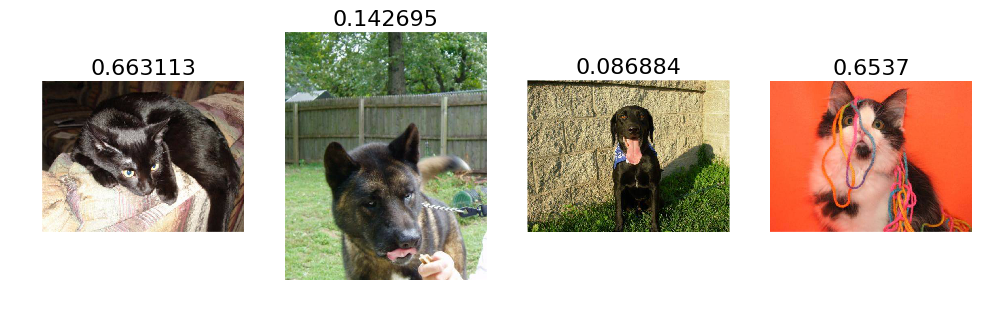

In [47]:
correct = np.where(preds==labels)[0]
idx = permutation(correct)[:nv]
plots_idx(idx, probs[idx])

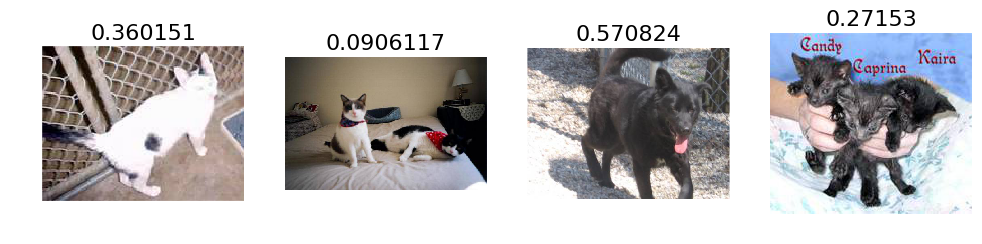

In [48]:
incorrect = np.where(preds!=labels)[0]
idx = permutation(incorrect)[:nv]
plots_idx(idx, probs[idx])

In [136]:
correct_cats = np.where((preds==labels) & (preds==0))[0]

In [78]:
correct_cats

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24])

In [79]:
probs[correct_cats]

array([ 0.8049,  0.8736,  0.8374,  0.8295,  0.6631,  0.8949,  0.9083,  0.6537,  0.9095,  0.91  ,
        0.8758,  0.9031,  0.9003,  0.6848,  0.8217,  0.9117,  0.8746,  0.9043,  0.8657,  0.9116,
        0.9038,  0.8582,  0.8889], dtype=float32)

In [80]:
most_correct_cats = np.argsort(probs[correct_cats])[:nv]

In [81]:
correct_cats[most_correct_cats]

array([ 8,  5, 14,  1])

In [82]:
probs[correct_cats][most_correct_cats]

array([ 0.6537,  0.6631,  0.6848,  0.8049], dtype=float32)

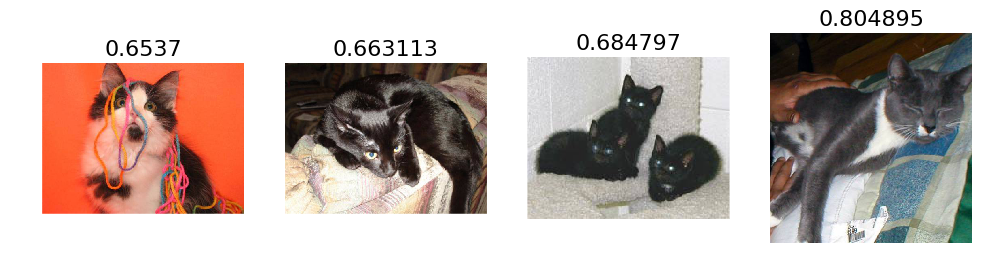

In [83]:
plots_idx(correct_cats[most_correct_cats], probs[correct_cats][most_correct_cats])

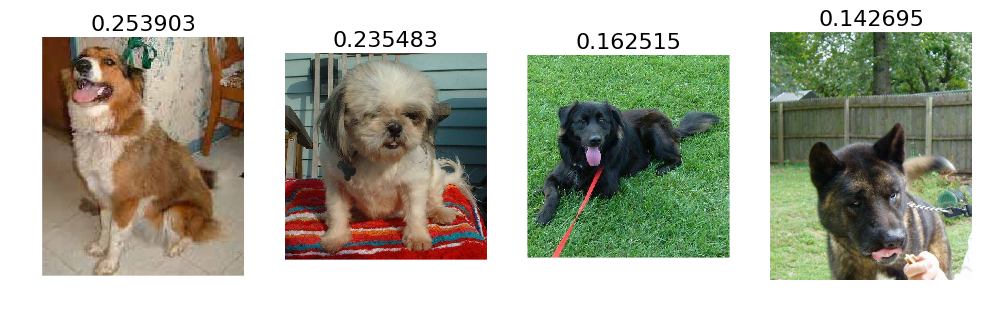

In [84]:
correct_dogs = np.where((preds==labels) & preds==1)[0]
most_correct_dogs = np.argsort(probs[correct_dogs])[::-1][:nv]
plots_idx(correct_dogs[most_correct_dogs], probs[correct_dogs][most_correct_dogs])

1 incorrect cats


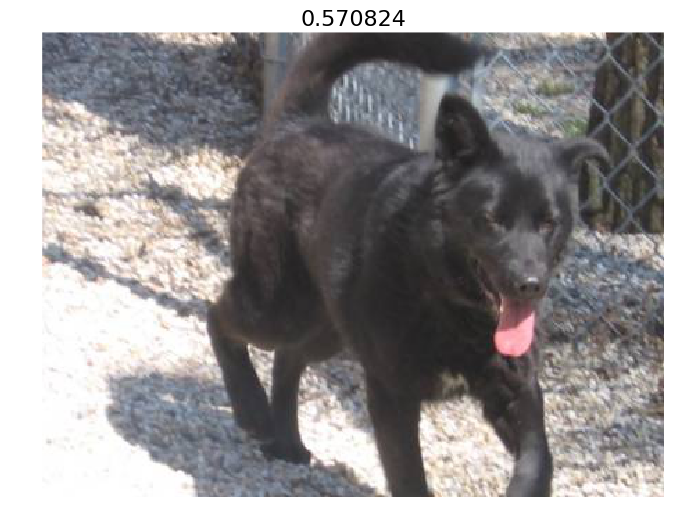

In [138]:
incorrect_cats = np.where((preds!=labels) & (preds==0))[0]
print("{} incorrect cats".format(len(incorrect_cats)))
most_incorrect_cats = np.argsort(probs[incorrect_cats])[:nv]
plots_idx(incorrect_cats[most_incorrect_cats], probs[incorrect_cats][most_incorrect_cats])

3 incorrect dogs


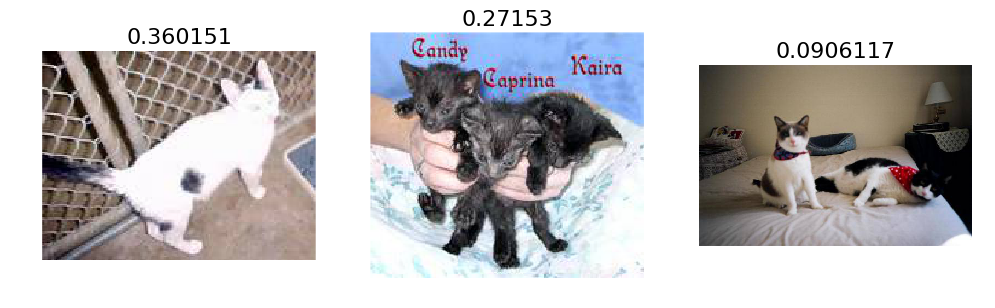

In [139]:
incorrect_dogs = np.where((preds!=labels) & (preds==1))[0]
print("{} incorrect dogs".format(len(incorrect_dogs)))
most_incorrect_dogs = np.argsort(probs[incorrect_dogs])[::-1][:nv]
plots_idx(incorrect_dogs[most_incorrect_dogs], probs[incorrect_dogs][most_incorrect_dogs])

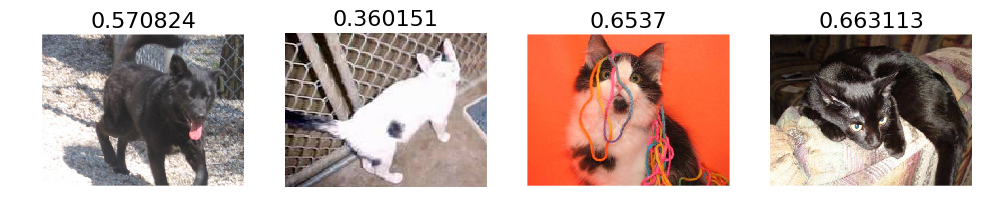

In [89]:
most_uncertain = np.argsort(np.abs(probs - 0.5))
plots_idx(most_uncertain[:nv], probs[most_uncertain])

In [95]:
import matplotlib.pyplot as plt

In [142]:
labels

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [145]:
preds

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [143]:
probs

array([ 0.2715,  0.8049,  0.8736,  0.8374,  0.8295,  0.6631,  0.8949,  0.9083,  0.6537,  0.9095,
        0.91  ,  0.8758,  0.9031,  0.9003,  0.6848,  0.8217,  0.9117,  0.3602,  0.8746,  0.9043,
        0.8657,  0.9116,  0.9038,  0.8582,  0.8889,  0.0906,  0.0899,  0.0453,  0.0684,  0.073 ,
        0.5708,  0.0588,  0.2355,  0.0653,  0.1625,  0.0986,  0.0698,  0.1182,  0.0607,  0.1293,
        0.1365,  0.0438,  0.0578,  0.0759,  0.0802,  0.1189,  0.0869,  0.1427,  0.1281,  0.2539], dtype=float32)

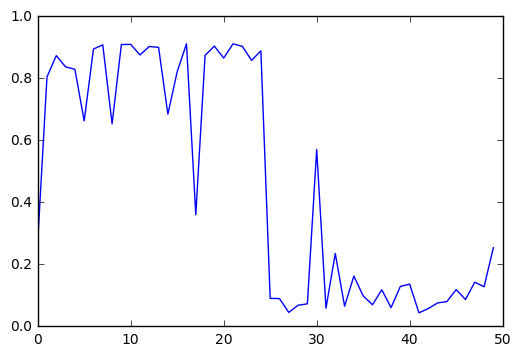

In [144]:
plt.plot(range(len(probs)), probs)

How can we understand this? It makes sense if you think of labels and probs as unrelated.

The cat ***label*** is 0. A 0 in both labels and preds means "cat". But when it comes to probs, the value is the probability of the image being the first label (cat or 0). So the closer the value of probs to 1, the more likely a pred of 0. It's confusing.

[[23  3]
 [ 1 23]]


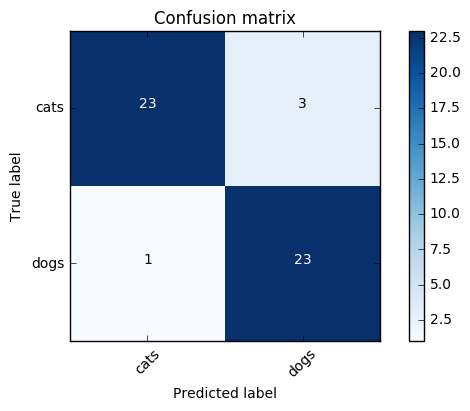

In [90]:
cm = confusion_matrix(val_classes, preds)
plot_confusion_matrix(cm, val_batches.class_indices)

In [146]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [147]:
model.pop()
for layer in model.layers:
    layer.trainable = False

In [148]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

** We removed the last dense layer - but also all the params went to 0**

In [149]:
model.add(Dense(2, activation="softmax"))

In [152]:
gen = image.ImageDataGenerator() # Generate minibatches with real-time data augmentation, whatever that means
batches = gen.flow(trn_data, trn_labels, batch_size=64, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=64, shuffle=True)

**Wtf is gen.flow? **

Takes numpy data & label arrays, and generates batches of augmented/normalized data. Yields batches indefinitely, in an infinite loop

Probably the lower level function of get_batches (vgg.get_batches)

We increased the batch_size because it's time for REAL deep learning I guess

In [153]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(
        batches,
        samples_per_epoch=batches.N,
        nb_epoch=nb_epoch,
        validation_data=val_batches,
        nb_val_samples=val_batches.N
    )
    # Fits the model on data generated batch-by-batch by a Python generator.
    # The generator is run in parallel to the model, for efficiency.
    # For instance, this allows you to do real-time data augmentation on images on CPU in parallel to training your model on GPU.

This looks similar to the lm.fit before:
```
lm.fit(
    trn_features, # training x
    trn_labels, # training y
    nb_epoch=3,
    batch_size=64,
    validation_data=(
        val_features,
        val_labels
    )
)
```
So a "batch" is just a way of feeding images to a fit function (makes sense since even one image is like [3, 244, 244])

In [154]:
model.compile(optimizer=RMSprop(lr=0.1), loss="categorical_crossentropy", metrics=["accuracy"])

In [155]:
fit_model(model, batches, val_batches, nb_epoch=3)

Epoch 1/3
200/200 [==============================] - 7s - loss: 6.2534 - acc: 0.4450 - val_loss: 8.3814 - val_acc: 0.4800
Epoch 2/3
200/200 [==============================] - 6s - loss: 6.8502 - acc: 0.5750 - val_loss: 8.3814 - val_acc: 0.4800
Epoch 3/3
200/200 [==============================] - 6s - loss: 6.8502 - acc: 0.5750 - val_loss: 8.3814 - val_acc: 0.4800


Apparently this calculates all previous layers in order to know what input to pass to the new final layer.

In [156]:
model.save_weights(model_dir + "sampleft1.h5")

In [157]:
model.evaluate(val_data, val_labels)

50/50 [==============================] - 1s     


[8.3814099550247292, 0.47999999999999998]

In [158]:
preds = model.predict_classes(val_data, batch_size=4)
probs = model.predict_proba(val_data, batch_size=4)[:,0]
probs[:5]

50/50 [==============================] - 1s     


array([ 0.,  0.,  0.,  0.,  0.], dtype=float32)

In [159]:
cm = confusion_matrix(val_classes, preds)

[[ 0 26]
 [ 0 24]]


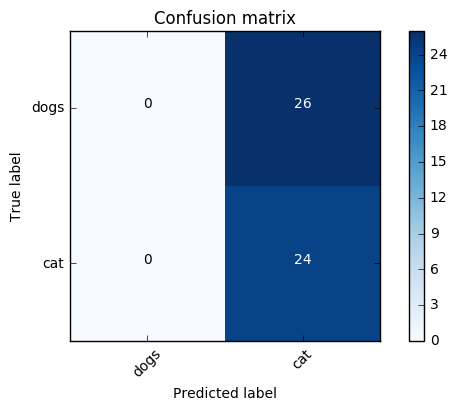

In [160]:
plot_confusion_matrix(cm, {"cat": 0, "dogs": 1})